## Imports

In [ ]:
%pylab inline
import pandas as pd 
import requests
from bs4 import BeautifulSoup
import pickle
import seaborn as sns
from datetime import datetime

%load_ext autoreload
%autoreload 2

In [2]:
#https://www.statsmodels.org/dev/generated/statsmodels.tsa.arima_model.ARIMA.html
from statsmodels.tsa.arima_model import ARIMA

## Data loading & cleaning

In [77]:
from helper import clean_data
from helper import vix_prime_combine

In [78]:
pct_df, vix_close , prime, weekly_vix, monthly_vix = clean_data()

In [79]:
from helper import split_data

In [80]:
df_len = pct_df.shape[0]
train = pct_df.iloc[:df_len-200,0]
train = train.values
validation = pct_df.iloc[df_len-200:df_len-100,0]
validation = validation.values
test = pct_df.iloc[df_len-100:,0]

In [81]:
model = ARIMA(train, order=(1,0,0)).fit()

/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

In [82]:
def RMSE(validation_points, prediction_points):
   """
   Calculate RMSE between two vectors
   """
   x = np.array(validation_points)
   y = np.array(prediction_points)

   return np.sqrt(np.mean((x - y)**2))


In [83]:
def test_model(df,p,q):
    preds = []
    df = list(df)

    for i in validation:
        model = ARIMA(df, order=(p,0,q)).fit()
        pred = model.forecast()[0][0]
        preds.append(pred)
        df.append(i)

    #plt.plot(validation)
    #plt.plot(preds)
    
    return RMSE(validation,np.array(preds))


In [84]:
test_model(train,1,0)

0.0378392338537955

In [ ]:
res= []
for i in range(1,5):
    for q in range(1,2):
        model = ARIMA(train,order=(i,0,q)).fit().forecast(100)
        res.append([i,q,RMSE(validation,model[0])])
        
res

These all do worse. Best is 7,0,1 at RMSE = 0.04635423458910249

In [12]:
# define helper plot function for visualization
import statsmodels.tsa.api as smt

def plots(data, lags=None):
    layout = (1, 3)
    raw  = plt.subplot2grid(layout, (0, 0))
    acf  = plt.subplot2grid(layout, (0, 1))
    pacf = plt.subplot2grid(layout, (0, 2))
    
    data.plot(ax=raw, figsize=(12, 6))
    smt.graphics.plot_acf(data, lags=lags, ax=acf)
    smt.graphics.plot_pacf(data, lags=lags, ax=pacf)
    sns.despine()
    plt.tight_layout()

In [32]:
test_train = pct_df.iloc[:df_len-20,0]

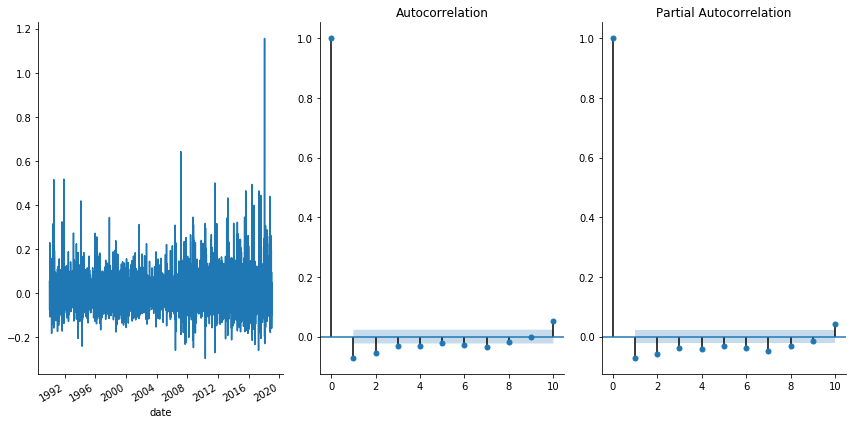

In [33]:
plots(test_train,lags=10)

In [ ]:
# res = []
# for i in range(1,5):
#     res.append(test_model(train,i,1))
# res

## SARIMA

In [42]:
import statsmodels.api as sm

In [67]:
sar = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), seasonal_order=(0,0,0,12), trend='c').fit()

In [68]:
pred = sar.get_prediction(0,99)

In [69]:
RMSE(validation,pred.predicted_mean)

0.03882526790237351

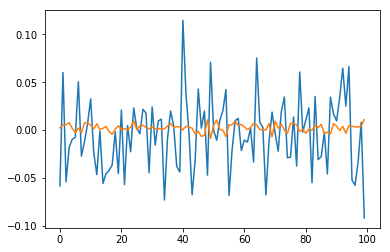

In [70]:
plt.plot(validation)
plt.plot(pred.predicted_mean)

## Include Exogenous variables (SARIMAX)

In [72]:
monthly_vix = pct_df.resample('M').sum()